## Load dataset

In [14]:
from skfp.datasets.moleculenet import load_bace

smiles_list, y = load_bace()

print(f"Example molecule: {smiles_list[0]}")
print(f"Example class: {y[0]}")

Example molecule: O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C
Example class: 1


### Transform SMILES representation to molecular graphs

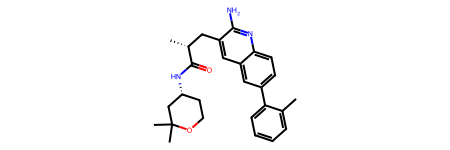

In [15]:
from skfp.preprocessing import MolFromSmilesTransformer

mol_from_smiles = MolFromSmilesTransformer()

mols = mol_from_smiles.transform(smiles_list)
mols[0]

### Split the data

How it's done normally

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np

train_idxs, test_idxs = train_test_split(range(len(smiles_list)), test_size=0.2)

mols_train = np.array(mols)[train_idxs]
mols_test = np.array(mols)[test_idxs]

y_train = y[train_idxs]
y_test = y[test_idxs]

print(f"Train set size: {len(mols_train)}")
print(f"Test set size: {len(mols_test)}")

Train set size: 1210
Test set size: 303


How it's done in chemoinformatics and why

exercise - import scaffold split, pass molecules, there's an argument that will allow you to return split indices

In [17]:
import numpy as np
from skfp.model_selection import scaffold_train_test_split

train_idxs, test_idxs = scaffold_train_test_split(
    mols, test_size=0.2, return_indices=True
)

# split mols and labels
mols_train = np.array(mols)[train_idxs]
mols_test = np.array(mols)[test_idxs]

y_train = y[train_idxs]
y_test = y[test_idxs]

print(f"Train set size: {len(mols_train)}")
print(f"Test set size: {len(mols_test)}")

Train set size: 1210
Test set size: 303


If we try to pass molecules to a model it won't work

In [18]:
from sklearn.ensemble import RandomForestClassifier

try:
    clf = RandomForestClassifier(n_jobs=-1, random_state=0)
    clf.fit(mols_train, y_train)
except TypeError as error:
    print(error)

float() argument must be a string or a real number, not 'Mol'


We need to represent the data as vectors!

A few slides about Fingerprints to give a general idea of what we want the algorithms to do, and example fingerprint at the end

In [19]:
from skfp.fingerprints import MACCSFingerprint

# create fingerprint transformer object
maccs_fp = MACCSFingerprint(n_jobs=-1)

# transform molecules into feature vectors
X_train_maccs = maccs_fp.transform(mols_train)
X_test_maccs = maccs_fp.transform(mols_test)

print(f"Fingerprint data shape: {X_train_maccs.shape}")
print(f"Example vector: {X_train_maccs[0]}")

Fingerprint data shape: (1210, 166)
Example vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1
 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0]


Explain hashed fingerprints and count here

Exercise - use another fingerprint - ECFP in count variant.

In [20]:
from skfp.fingerprints import ECFPFingerprint

# create fingerprint transformer object
ecfp_fp = ECFPFingerprint(radius=3, count=True, fp_size=1024, n_jobs=-1)

# transform molecules into feature vectors
X_train_ecfp = ecfp_fp.transform(mols_train)
X_test_ecfp = ecfp_fp.transform(mols_test)

print(f"Fingerprint data shape: {X_train_ecfp.shape}")
print(f"Example vector: {X_train_ecfp[0]}")

Fingerprint data shape: (1210, 1024)
Example vector: [0 1 0 ... 0 0 0]


Train a random forest model

In [21]:
from sklearn.ensemble import RandomForestClassifier
from skfp.metrics import multioutput_auroc_score

clf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf.fit(X_train_ecfp, y_train)

y_pred = clf.predict_proba(X_test_ecfp)[:, 1]
auroc = multioutput_auroc_score(y_test, y_pred)

print(f"ECFP AUROC for Random Forest: {auroc:.2%}")

ECFP AUROC for Random Forest: 76.87%


Distances

In [22]:
# import Tanimoto count distance from scikit-fingerprints
from sklearn.neighbors import KNeighborsClassifier
from skfp.distances import tanimoto_count_distance

tanimoto_count_distance(X_train_ecfp[0], X_train_ecfp[1])

0.7264150943396226

Explain quickly what knn is, and that it takes a distance function as metric argument.

Tell them

In [23]:
# create kNN model with appropriate metric
clf = KNeighborsClassifier(n_jobs=-1, metric=tanimoto_count_distance)

# fit, predict
clf.fit(X_train_ecfp, y_train)
y_pred = clf.predict_proba(X_test_ecfp)[:, 1]

# calculate and print AUROC score
print(f"ECFP AUROC for kNN: {multioutput_auroc_score(y_test, y_pred):.2%}")

ECFP AUROC for kNN: 77.64%
